# Libraries uploading

In [1]:
#basic operations
from typing import Union, Tuple, Optional
import os

#data handling 
import segyio

#math core
import numpy as np
from numpy.random import RandomState

import scipy
from scipy import signal
from scipy.optimize import minimize
from scipy.signal import butter, tukey, filtfilt

#visualization core
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# Defining functions

In [2]:
class Operator:
    """
    A class containing static methods to generate convolution operators for various purposes.
    """
    @staticmethod
    def _convolve_operator(kernel: Union[list, np.ndarray], nt: int, offset: Optional[int] = None) -> np.ndarray:
        """
        Computes the discrete linear convolution operator for two one-dimensional sequences.

        Args:
            kernel (list or np.ndarray): First input array.
            nt (int): Length of the output array after convolution.
            offset (int, optional): Offset (default is half the length of `kernel`).

        Returns:
            np.ndarray: Convolution operator (nt, nt).

        Example:
            >>> kernel = [1, 2, 3]
            >>> nt = 5
            >>> result = convolve_operator(kernel, nt)
            >>> print(result)
            [[2. 3. 0. 0. 0.]
             [1. 2. 3. 0. 0.]
             [0. 1. 2. 3. 0.]
             [0. 0. 1. 2. 3.]
             [0. 0. 0. 1. 2.]]
        """
        try:
            # Calculate the offset if not provided
            offset = len(kernel) // 2 if offset is None else offset

            # Construct the first column and first row for Toeplitz matrix
            first_col, first_row = np.r_[kernel, np.zeros(nt + offset)], np.r_[kernel[0], np.zeros(nt - 1)]

            # Create the Toeplitz matrix and extract the relevant part
            operator = scipy.linalg.toeplitz(first_col, first_row)[offset: offset + nt]

            return operator
        except Exception as e:
            print(f"Error in _convolve_operator: {e}")
            return np.array([])

    @classmethod
    def first_derivative(cls, nt: int, mode: str = "forward") -> np.ndarray:
        """
        Generates a first-order derivative convolution operator.

        Args:
            nt (int): Length of the output array after convolution.

        Returns:
            np.ndarray: First-order derivative convolution operator (nt, nt).
            
        Example:
            >>> nt = 4
            >>> result = first_derivative(nt)
            >>> print(result)
            [[-1.  1.  0.  0.]
             [ 0. -1.  1.  0.]
             [ 0.  0. -1.  1.]
             [ 0.  0.  0.  0.]]
        
        """
        
        try:
            if mode == "forward":
                operator = cls._convolve_operator([1, -1], nt, offset=1)
                operator[-1, :] = 0
            elif mode == "centered":
                operator = cls._convolve_operator([1, 0,-1], nt)
            return operator
        except Exception as e:
            print(f"Error in first_derivative: {e}")
            return np.array([])

    @classmethod
    def second_derivative(cls, nt: int) -> np.ndarray:
        """
        Generates a second-order derivative convolution operator.

        Args:
            nt (int): Length of the output array after convolution.

        Returns:
            np.ndarray: Second-order derivative convolution operator (nt, nt).
        """
        try:
            operator = cls._convolve_operator([-1, 2, -1], nt, offset=2)
            operator[-2:, :] = 0
            return operator
        except Exception as e:
            print(f"Error in second_derivative: {e}")
            return np.array([])

    @classmethod
    def wavelet_operator(cls, wavelet: Union[list, np.ndarray], nt: int) -> np.ndarray:
        """
        Generates a convolution operator using the provided wavelet.

        Args:
            wavelet (list or np.ndarray): Wavelet array.
            nt (int): Length of the output array after convolution.

        Returns:
            np.ndarray: Convolution operator using the provided wavelet (nt, nt).
        """
        try:
            operator = cls._convolve_operator(wavelet, nt)
            return operator
        except Exception as e:
            print(f"Error in wavelet_operator: {e}")
            return np.array([])

    @classmethod
    def acoustic(cls, wavelet: Union[list, np.ndarray], nt: int) -> np.ndarray:
        """
        Computes the acoustic operator (W*D, according to the convolutional model of seismic trace) 
        for a given wavelet and length of the output array.

        Args:
            wavelet (list or np.ndarray): One-dimensional array representing the wavelet.
            nt (int): Length of the output array.

        Returns:
            np.ndarray: Acoustic operator (nt, nt).

        Example:
            >>> wavelet = [1, -1, 2]
            >>> nt = 4
            >>> result = acoustic_operator(wavelet, nt)
            >>> print(result)
            [[-1.  2. -1.  0.]
             [ 2. -3.  2. -1.]
             [ 0.  2. -3.  2.]
             [ 0.  0.  2. -3.]]
        """
        try:
            return cls.wavelet_operator(wavelet, nt) @ cls.first_derivative(nt)
        except Exception as e:
            print(f"Error in acoustic: {e}")
            return np.array([])
    

    @classmethod
    def akirichards(cls, theta: Union[list, np.ndarray], 
                vsvp: Union[float, np.ndarray], nt: int = 2,) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Computes the Aki-Richards approximation for reflection coefficients.

        Args:
            theta (list or np.ndarray): Incident angles in degrees.
            vsvp (float or np.ndarray): Ratio of S-wave velocity to P-wave velocity.
            nt (int, optional): Number of discrete (default is 1).

        Returns:
            Tuple[np.ndarray, np.ndarray, np.ndarray]: Reflection coefficients (G1, G2, G3).

        Example:
            >>> theta_deg = [10, 20, 30]
            >>> vsvp = 0.56
            >>> G1, G2, G3 = akirichards(theta_deg, vsvp)
            >>> print(G1, G2, G3)
        """
        # Convert incident angles to radians
        theta = np.deg2rad(theta) 

        # Ensure vsvp is an array
        vsvp = vsvp * np.ones(len(vp_trace)) if not isinstance(vsvp, np.ndarray) else vsvp  #тернарный оператор для превращения vsvp в массив

        # Compute Aki-Richards coefficients
        G1 = 1.0 / (2.0 * np.cos(theta[:, np.newaxis] ) ** 2) + 0*vsvp
        G2 = -4.0 * vsvp**2 * np.sin(theta[:, np.newaxis] ) ** 2
        G3 = 0.5 - 2.0 * vsvp**2 * np.sin(theta[:, np.newaxis] ) ** 2

        return G1, G2, G3
        
    @classmethod
    def avo(cls, wavelet: np.ndarray, theta: np.ndarray, 
                 vsvp: Union[float, np.ndarray] = 0.5, nt: int = 1, linearization: str = "akirich") -> np.ndarray:
        
        theta_rad = np.deg2rad(theta)
        vsvp = vsvp * np.ones(len(vp_trace)) if not isinstance(vsvp, np.ndarray) else vsvp

        G = cls.akirichards(theta_rad, vsvp, nt)

        # Create block matrix G
        G_blocks = [
        np.hstack([np.diag(G[i][itheta] * np.ones(nt)) for i in range(3)])
        for itheta in range(len(theta))
        ] 
        G = np.vstack(G_blocks)

        # Create block matrix D
        D_blocks = [np.hstack([cls.first_derivative(nt) for _ in range(3)]) for _ in theta]
        D = np.vstack(D_blocks)

        # Create block matrix W
        W_blocks = [np.hstack([cls.wavelet_operator(wavelet[:, itheta], nt) for itheta in range(len(theta))]) for _ in range(3)]
        W = np.vstack(W_blocks)

        WD = W@D
        res = G@WD
        return res    
    
    @classmethod
    def fatti(cls, input_data) -> np.ndarray:
        pass
    
    @classmethod
    def ps(cls, input_data) -> np.ndarray:
        pass
    
    @classmethod
    def zoeppritz(cls, input_data) -> np.ndarray:
        pass
    
    @classmethod
    def tikhonov(cls, nt: int, coefficients: Union[list, np.ndarray]) -> np.ndarray:
        """
        Computes the Tikhonov regularization operator for ill-posed problems.

        Args:
            nt (int): Length of the output matrix.
            coefficients (Union[list, np.ndarray]): Regularization coefficients.

        Returns:
            np.ndarray: Tikhonov regularization operator.

        Example:
            >>> nt = 2
            >>> coefficients = [1, 2, 3]
            >>> result = tikhonov_operator(nt, coefficients)
            >>> print(result)
            [[1   0.]
             [0.  1 ]
             [2.  0.]
             [0.  2.]
             [3.  0.]
             [0.  3.]]
        """
        # Create a diagonal matrix with regularization coefficients
        return np.concatenate([np.diag(num*np.ones(nt)) for num in coefficients], axis = 1)
    
class Data_handling:
    def __init__(self, impulses_path: str = None, wells_path: str = None, horizons_path: str = None, cube_path: str = None):
        """
        :param impulses_path: путь к фолдеру импульсов.
        :param wells_path: путь к фолдеру ласов.
        :param horizons_path: путь к фолдеру горизонтов.
        :param cube_path: путь к SEGY файлу сейсмокуба.
        """
        self.impulses_folder_path = impulses_path
        self.wells_folder_path = wells_path
        self.horizons_folder_path = horizons_path
        self.cube = segyio.tools.cube(cube_path) if cube_path else None

    @staticmethod
    def interpolate_signal(signal):
        """
        :param signal: сигнал для интероляции.
        :return: ресемплированный нормированный сигнал.
        """
        interp_func = interp1d(np.arange(len(signal)), signal, kind='cubic')

        new_x = np.linspace(0, len(signal) - 1, 100)

        new_signal = interp_func(new_x)
    
        return new_signal / np.max(new_signal)
    
    def parse_signals_in_folder(self):
        all_txt = []  # лист для вейвлетов

        try:
            for filename in os.listdir(self.impulses_folder_path):
                file_path = os.path.join(self.impulses_folder_path, filename) 
                if os.path.isfile(file_path):  
                    all_txt.append(self.interpolate_signal(np.loadtxt(file_path)))

        except FileNotFoundError:
            print(f"Folder '{self.impulses_folder_path}' not found.")
        except Exception as e:
            print("An error occurred:", e)

        return all_txt  
    
    def parse_wells_in_folder(self):
        """
        
        Parse well log data from LAS files in the specified folder.

        Считывает LAS файлы, выбирает нужные кривые, собирает их в NumPy array.
        RHOB, DTP, DPTM.

        Returns:
            all_lases (list): Лист NumPy arrays с нужными каротажками.
        """
        all_lases = []  

        try:
            for filename in os.listdir(self.wells_folder_path):
                if filename.endswith('.LAS'):
                    file_path = os.path.join(self.wells_folder_path, filename)  
                    if os.path.isfile(file_path): 
                        las = lasio.read(file_path)  
                        all_lases.append(np.column_stack((las["DEPTH"].T, las["RHOB"].T, 1e7/las["DTP"].T, las["DPTM"])))

        except FileNotFoundError:
            print(f"Folder '{self.wells_folder_path}' not found.")
        except Exception as e:
            print("An error occurred:", e)

        return all_lases  
    
    def parse_horizons_in_folder(self):
        """
        Считывает файлы горизонтов из фолдера (Charisma dtype).

        Returns:
            all_horizons (list): Лист NumPy arrays с горизонтами.
        """
        all_horizons = [] 
        try:
            for filename in os.listdir(self.horizons_folder_path):
                file_path = os.path.join(self.horizons_folder_path, filename)  
                if os.path.isfile(file_path): 
                    with open(file_path, "r") as f:
                        horizon = np.loadtxt(f, skiprows=0, usecols=(2,5,8)).astype(np.float32)
                        all_horizons.append(horizon) 
        except FileNotFoundError:
            print(f"Folder '{self.horizons_folder_path}' not found.")
        except Exception as e:
            print("An error occurred:", e)
            
        #WARNING! обрезал из-за разных границ у горизонтов           
#         for i in range(len(all_horizons)):
#             if i > 0:
#                 all_horizons[i] = all_horizons[i][:-17, :]
#             else:
#                 all_horizons[i] = all_horizons[i][363:, :]
    
        def get_surfaces(horizon):
            """
            Собирает 2D массив горизонта.

            :param horizon: NumPy array с X, Y и Z координатами.
            :return: A 2D NumPy array горизонта.
            """
            min_Y, max_Y = np.min(horizon[:, 1]), np.max(horizon[:, 1])
            min_X, max_X = np.min(horizon[:, 0]), np.max(horizon[:, 0])
            X = np.arange(min_X, max_X, dtype="int32")
            Y = np.arange(min_Y, max_Y, dtype="int32")
            surf = np.empty((X.shape[0], Y.shape[0]))

            for i in range(horizon.shape[0]):
                x_index = (horizon[i, 0] - min_X - 1).astype("int32")
                y_index = (horizon[i, 1] - min_Y - 1).astype("int32")
                surf[x_index, y_index] = horizon[i, 2] / 2

            return surf
        surfaces = [get_surfaces(horizon) for horizon in all_horizons]

        return all_horizons, surfaces

In [3]:
def mse(L: Union[list, np.ndarray], L0: Union[list, np.ndarray], T: Union[list, np.ndarray],
        approximation: Union[list, np.ndarray], tikhonov: Union[list, np.ndarray]) -> float:
    """
    Computes the Mean Squared Error (MSE) between modeled seismic trace and real trace.

    Args:
        L (list or np.ndarray): Low-frequency model to change.
        L0 (list or np.ndarray): Low-frequency model.
        T (list or np.ndarray): Real seismic trace to compare.
        acoustic_operator (list or np.ndarray): Acoustic operator matrix.
        alpha (float or int): Regularization parameter.

    Returns:
        float: Mean Squared Error.

    Example:
        >>> L = [1, 2, 3]
        >>> L0 = [0, 0, 0]
        >>> T = [1, 2, 3]
        >>> acoustic_operator = [[-1, 1, 0], [1, -1, 2], [0, 1, -1]]
        >>> alpha = 0.1
        >>> result = mse(L, L0, T, acoustic_operator, alpha)
        >>> print(result)
        5.374165738677394
    """
    L, L0, T, approximation = np.array(L), np.array(L0), np.array(T), np.array(approximation)
    # Compute the main term of the MSE
#     main_term = np.mean(np.sqrt((np.square((approximation@L) - T))))
    main_term = np.linalg.norm(approximation@L - T, ord = 2)
    
    # Compute the regularization term of the MSE
#     regularization_term = np.mean(np.sqrt(np.square((tikhonov@(L - L0)))))
    regularization_term = np.linalg.norm(tikhonov@(L - L0), ord = 2)
    # Return the sum of main and regularization terms
    return main_term + regularization_term

def butter_lowpass_filter(data, cutoff, fs, order):
    """
    Lowpass filter
    fs - sample rate (шаг дискретизации), Hz
    cutoff - desired cutoff frequency of the filter (желаемая частота среза фильтра), Hz
    order - sin wave can be approx represented as quadratic
    """
    normal_cutoff = 2*cutoff / fs
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

# Data handling

In [4]:
stack_0_18 = segyio.tools.cube(r"Prestack\stack_0_18")
stack_17_26 = segyio.tools.cube(r"Prestack\stack_17_26")
stack_25_34 = segyio.tools.cube(r"Prestack\stack_25_34")
stack_33_42 = segyio.tools.cube(r"Prestack\stack_33_42")

seismic_cubes = {"0": stack_0_18, "1": stack_17_26, "2": stack_25_34, "3": stack_33_42}

In [5]:
lfm_vp = segyio.tools.cube(r"Prestack\SInv_case\Seismic_stacks_segy\LFM_VP.segy")
lfm_vs = segyio.tools.cube(r"Prestack\SInv_case\Seismic_stacks_segy\LFM_VS.segy")
lfm_rhob = segyio.tools.cube(r"Prestack\SInv_case\Seismic_stacks_segy\LFM_RHOB.segy")

FileNotFoundError: [Errno 2] No such file or directory

In [6]:
env = Data_handling(horizons_path = r"Prestack\SInv_case\Horizons_charisma")

In [7]:
surfaces, horizons = env.parse_horizons_in_folder()

In [8]:
x = np.int64(horizons[:][0]).ravel()
y = np.int64(horizons[:][1]).ravel() 
z = np.int64(horizons[:][2]).ravel()

In [9]:
sx, sy, sz = stack_25_34.shape

inline_start, inline_end = 1400, 1600
crline_start, crline_end = 1050, 1250
well_inline, well_crline = 1535-inline_start, 1143-crline_start

In [10]:
vp_trace = lfm_vp[well_inline, well_crline, :]
vs_trace = lfm_vs[well_inline, well_crline, :]
rhob_trace = lfm_rhob[well_inline, well_crline, :]

seis_trace_0_18 = stack_0_18[well_inline, well_crline, :]
seis_trace_17_26 = stack_17_26[well_inline, well_crline, :]
seis_trace_25_34 = stack_25_34[well_inline, well_crline, :]
seis_trace_33_42 = stack_33_42[well_inline, well_crline, :]

NameError: name 'lfm_vp' is not defined

In [11]:
seismic_batch = np.stack((seis_trace_0_18, seis_trace_17_26, seis_trace_25_34, seis_trace_33_42), axis = 1)

NameError: name 'seis_trace_0_18' is not defined

In [12]:
wav_1 = np.loadtxt(r"Prestack\SInv_case\Wavelets\SNR_final_0_18.txt")
wav_2 = np.loadtxt(r"Prestack\SInv_case\Wavelets\SNR_final_17_26.txt")
wav_3 = np.loadtxt(r"Prestack\SInv_case\Wavelets\SNR_final_25_34.txt")
wav_4 = np.loadtxt(r"Prestack\SInv_case\Wavelets\SNR_final_33_42.txt")

wav = np.stack((wav_1, wav_2, wav_3, wav_4), axis = 1)

In [13]:
m = np.stack((np.log(vp_trace), np.log(vs_trace), np.log(rhob_trace)), axis = 1)

NameError: name 'vp_trace' is not defined

In [14]:
ntheta = 4
theta = np.array([9, 22, 30, 37])

In [15]:
vsvp = np.mean(vs_trace/vp_trace)
nt0 = sz

In [16]:
import pylops

In [17]:
PPop = pylops.avo.prestack.PrestackLinearModelling(
    wav[0, :], theta, vsvp=vsvp, nt0=nt0, linearization="akirich"
)

In [18]:
# data lop
dPP = PPop * m.ravel()
dPP = dPP.reshape(nt0, ntheta)

UFuncTypeError: Cannot cast ufunc 'divide' output from dtype('float64') to dtype('int32') with casting rule 'same_kind'

In [19]:
# dense
PPop_dense = pylops.avo.prestack.PrestackLinearModelling(
    wav[0, :], theta, vsvp=vsvp, nt0=nt0, linearization="akirich", explicit=True
)

C:\Users\Korchuganovvd\AppData\Roaming\Python\Python311\site-packages\pylops\utils\signalprocessing.py:46: FutureWarning: A new implementation of convmtx is provided in v2.2.0 to match MATLAB's convmtx method as stated in the docstring. The implementation of convmtx provided prior to v2.2.0 was instead not consistent with the documentation. Users are highly encouraged to modify their codes accordingly.
  warnings.warn(


In [20]:
# data dense
dPP_dense = PPop_dense * m.T.ravel()
dPP_dense = dPP_dense.reshape(ntheta, nt0).T

(601, 4)

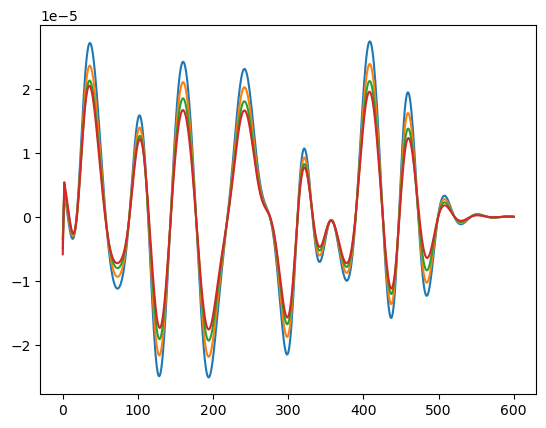

In [21]:
plt.plot(dPP_dense)
dPP_dense.shape

In [22]:
# dense
minv_dense, dPP_dense_res = pylops.avo.prestack.PrestackInversion(
    seismic_batch,
    theta,
    wav[0, :],
    m0=m,
    linearization="akirich",
    explicit=True,
    returnres=True,
    **dict(cond=1e-10)
)

In [23]:
minv, dPP_res = pylops.avo.prestack.PrestackInversion(
    seismic_batch,
    theta,
    wav[0, :],
    m0=m,
    linearization="akirich",
    explicit=True,
    epsI=np.hstack([4e-2*np.ones(sz), 2e-2*np.ones(sz), 8e-2*np.ones(sz)]),
    returnres=True
)

2404

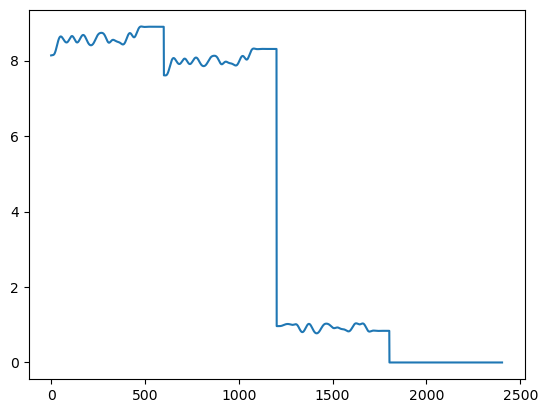

In [24]:
m_padded =  np.hstack((m.ravel("F"), np.zeros(sz)))
seis_raveled = seismic_batch.ravel("F")
plt.plot(m_padded)
len(seis_raveled)

In [25]:
vsvp

0.5598615

# Inversion procedure

In [26]:
result = minimize(mse,
                  x0 = m.ravel("F"),
                  args = (m.ravel("F"), 
                          seis_raveled/np.max(seis_raveled), 
                          Operator.avo(wav/np.max(wav), theta, vsvp = vsvp, nt = sz), 
                          Operator.tikhonov(sz, [0, 0, 0])),
                  method = 'l-bfgs-b',options={'disp': True}, 
                  tol = 1e-35)
curves = np.exp(result.x)

In [27]:
result

  message: STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
  success: False
   status: 1
      fun: 6.451220447125612
        x: [ 8.120e+00  8.133e+00 ...  8.278e-01  8.350e-01]
      nit: 7
      jac: [-1.743e-02 -3.330e-02 ...  3.154e-02  4.555e-02]
     nfev: 16236
     njev: 9
 hess_inv: <1803x1803 LbfgsInvHessProduct with dtype=float64>

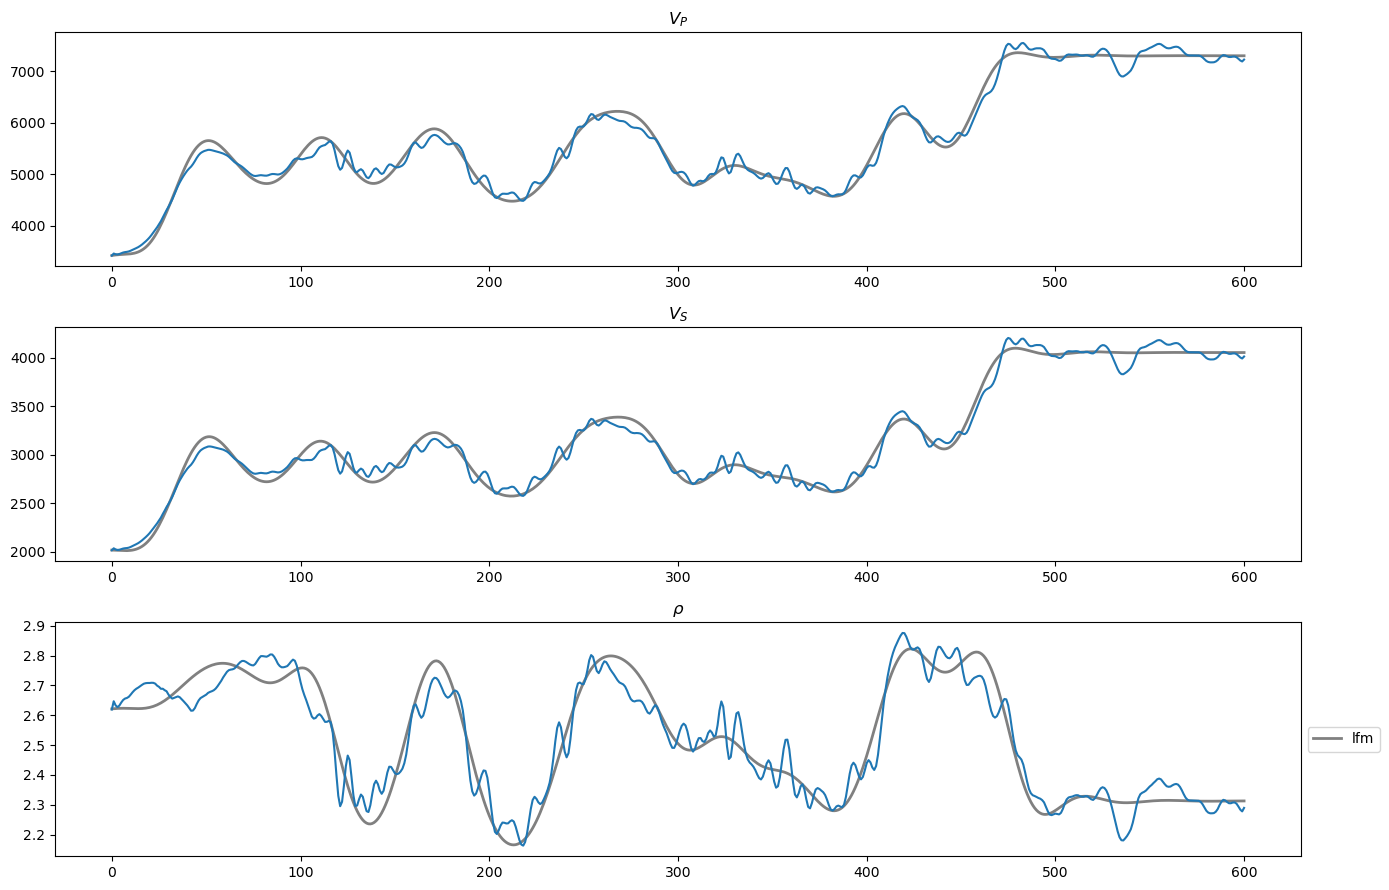

In [48]:
plt.figure(figsize = (14, 9))

plt.subplot(311)
plt.plot(np.exp(m[:, 0]), "gray", lw=2, label="lfm")
# plt.plot(curves[0:sz], "red")
# plt.plot(vp_res[100:500], "coral", lw=2, label="lfm")
# axvp.plot(np.exp(minv_dense[:, 0]), "--b", lw=2, label="Inv Dense")
# plt.plot(np.exp(minv[:, 0]), "coral", lw=2, label="Inv Lop")
plt.plot(np.exp(res_lsqr[:sz]))
plt.title(r"$V_P$")

plt.subplot(312)
plt.plot(np.exp(m[:, 1]),  "gray", lw=2, label="lfm")
# plt.plot(curves[sz:2*sz], "black")
# plt.plot(vs_res[:], "lime", lw=2, label="lfm")
# axvs.plot(np.exp(minv_dense[:, 1]), t0, "--b", lw=2, label="Inv Dense")
# plt.plot(np.exp(minv[:, 1]),  "C0", lw=2, label="Inv Lop")
plt.plot(np.exp(res_lsqr[sz:2*sz]))
plt.title(r"$V_S$")

plt.subplot(313)
plt.plot(np.exp(m[:, 2]),  "gray", lw=2, label="lfm")
# plt.plot(rhob_res[100:500], "purple", lw=2, label="lfm")
# plt.plot(np.exp(minv_dense[:, 2]), t0, "--b", lw=2, label="Inv Dense")
# plt.plot(curves[2*sz:3*sz], "green")
plt.plot(np.exp(res_lsqr[2*sz:3*sz]))
# plt.plot(np.exp(minv[:, 2]), "m", lw=2, label="Inv Lop")
plt.ylim([1, 4])
plt.title(r"$\rho$")

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.axis("tight")
plt.tight_layout()




In [28]:
import scipy.sparse.linalg 

In [29]:
m

array([[8.136799  , 7.608583  , 0.963629  ],
       [8.138454  , 7.608209  , 0.96387154],
       [8.139808  , 7.6077437 , 0.9640676 ],
       ...,
       [8.895385  , 8.307857  , 0.83836   ],
       [8.895382  , 8.307856  , 0.8383658 ],
       [8.895379  , 8.307853  , 0.8383678 ]], dtype=float32)

In [30]:
 np.exp(m.ravel("F"))

array([3.4179587e+03, 3.4236223e+03, 3.4282588e+03, ..., 2.3125713e+00,
       2.3125846e+00, 2.3125894e+00], dtype=float32)

In [47]:
res_lsqr = scipy.sparse.linalg.lsqr(Operator.avo(wav/np.max(wav), theta, vsvp = vsvp, nt = sz), 
                                           seis_raveled/np.max(seis_raveled), 
                                           x0 = m.ravel("F"),
                                           damp = 3e0)[0]

TypeError: unhashable type: 'slice'

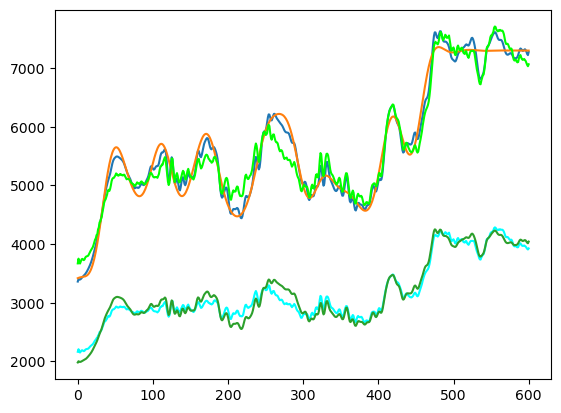

In [43]:
# for i in range(sz, ntheta*sz, 1803):
plt.plot(curves[0:sz])
plt.plot(np.exp(m[:, 0]))
plt.plot(np.exp(res_lsqr[:sz]), "lime")
plt.plot(np.exp(res_lsqr[sz:2*sz]), "aqua")
plt.plot(curves[sz:2*sz])
# plt.plot(np.exp(minv[:, 0]), "coral", lw=2, label="Inv Lop")
plt.plot(result[sz:2*sz])

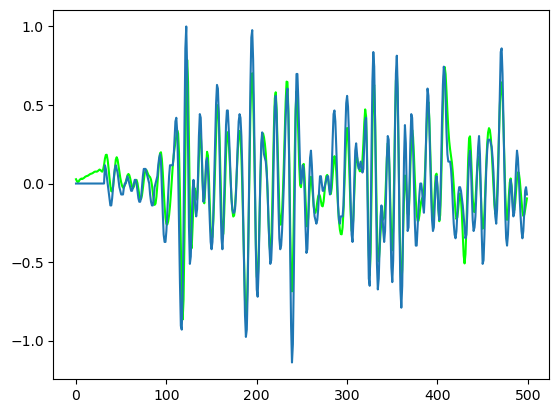

In [45]:
plt.plot((Operator.avo(wav/np.max(wav), theta, vsvp = vsvp, nt = sz)@res_lsqr)[:500], "lime")
plt.plot((seis_raveled/np.max(seis_raveled))[:500])

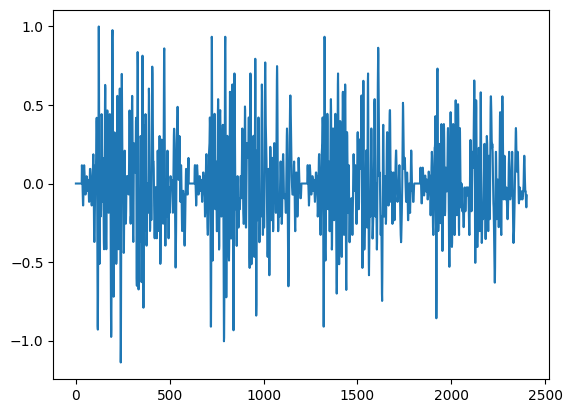

In [ ]:
# plt.plot(wav/np.max(wav))
plt.plot(seis_raveled/np.max(seis_raveled))

In [ ]:
result

array([3.41384067e+03, 3.42513858e+03, 3.42746114e+03, ...,
       2.30521695e+00, 2.30290803e+00, 2.30437712e+00])

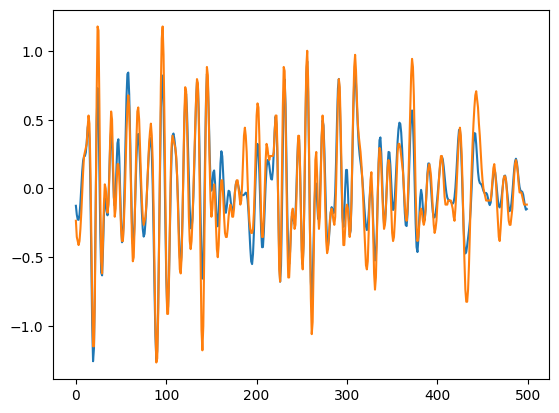

In [ ]:
plt.plot((Operator.avo(wav/np.max(wav), theta, vsvp = vsvp, nt = sz)@np.log(curves))[700:1200])
plt.plot(seis_raveled[700:1200])

(2404,)


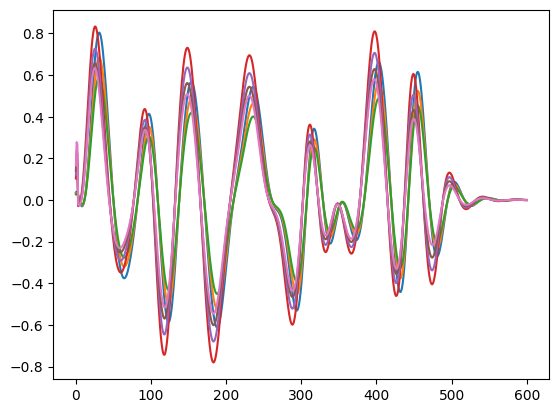

In [ ]:
G = Operator.akirichards(theta, vsvp, sz)
G_blocks = [
np.hstack([np.diag(G[i][itheta] * np.ones(sz)) for i in range(3)])
for itheta in range(len(theta))] 
G = np.vstack(G_blocks)

# Create block matrix D
D_blocks = [np.hstack([Operator.first_derivative(sz, mode = "forward") for _ in range(3)]) for _ in theta]
D = np.vstack(D_blocks)
# D[np.arange(sz-1, sz*len(theta), sz), :] = 0

# Create block matrix W
W_blocks = [np.hstack([Operator.wavelet_operator(wav[:, itheta], sz) for itheta in range(len(theta))]) for _ in range(3)]
W = np.vstack(W_blocks)


DIF = D
WDIF = W@DIF
GWDIF = G@WDIF
SEIS = GWDIF@m.ravel("F")



# DIF[np.arange(0, ntheta*sz, sz+1)] = 0
print(SEIS.shape)
for i in range(sz, ntheta*sz, sz):
    plt.plot(SEIS[0+i:sz+i])
    
plt.plot(dPP_dense*3e4)

In [ ]:
W[0, :]@m.ravel("F")

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1803 is different from 2404)

In [ ]:
ntheta*sz

2404

In [ ]:
W[3, :]

array([0.30155218, 1.57721731, 2.65778085, ..., 0.        , 0.        ,
       0.        ])

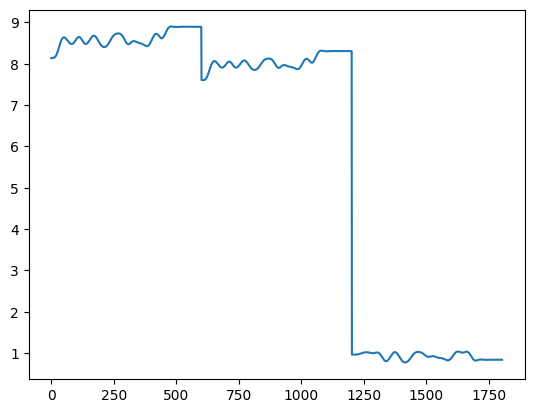

In [ ]:
plt.plot(m.ravel("F"))

In [ ]:
wav.shape

(65, 4)

(601,)


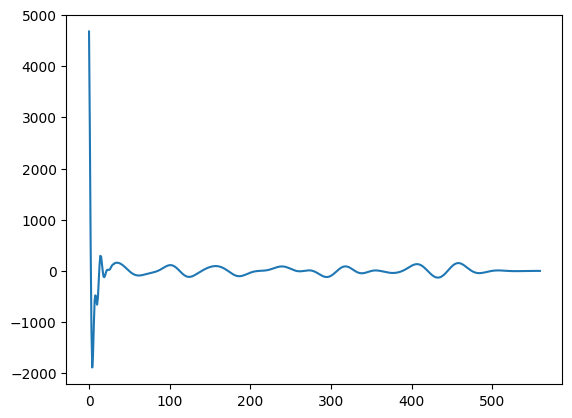

In [ ]:
GG = Operator.first_derivative(sz, mode = "forward")@Operator._convolve_operator(wav[:,0], sz)@np.diag(G[0][0] * np.ones(sz))@vp_trace
print(GG.shape)
plt.plot(GG[:560])
# plt.plot(1700*wav[:,0])
# plt.imshow(GG[:33, :50])

In [ ]:
correlation_coefficient = np.corrcoef(result, impedance_smoothed)[0, 1]

In [ ]:
plt.rcParams["font.family"] = "arial"

plt.figure(figsize = (8, 12))

plt.subplot(3, 1, 1)
plt.plot(impedance, "grey", lw = 0.3, label = "original")
plt.plot(impedance_smoothed, c = "aqua", lw = 1.5, zorder = 2, label = "smoothed")
plt.plot(result, c = "purple", lw = 1.2, zorder = 2, label = "inversion")
plt.plot(low_frequency_model, c = "gray", ls = "--", lw = 1, zorder = 1, label = "lfm")
plt.ylim([4500, 8500])
plt.yticks(np.arange(5e3, 8.1e3, 1e3))
plt.text(0.98, 0.96, 'R = {:.4f}'.format(correlation_coefficient),
         horizontalalignment='right',
         verticalalignment='top',
         transform=plt.gca().transAxes)
plt.title("Acoustic impedance traces")
plt.ylabel("Impedance")
plt.xlabel("Discretes")
plt.legend(fontsize = 8)


plt.subplot(5, 1, 3)
plt.plot(seismic_trace, c = "C0", lw = 2, label = "original")
plt.plot(Operator.acoustic(wavelet, nt)@np.log(result), c = "red", lw = 0.5, label = "inversion")
plt.ylim([-0.075, 0.075])
plt.title("Seismic traces")
plt.ylabel("Amplitude")
plt.xlabel("Discretes")
plt.legend()

In [ ]:
wavelet_extanded = np.hstack((np.zeros(50),wavelet))

plt.figure(figsize = (12, 7))
plt.subplot(211)
plt.title("wavelets")
plt.plot(wavelet, label = "centered wavelet")
plt.plot(wavelet_extanded, label = "shifted wavelet")
plt.legend()

plt.subplot(212)
plt.title("convolution in fft mode")
plt.plot(scipy.signal.convolve(Operator.first_derivative(nt)@np.log(result) ,wavelet, mode = "full", method = "fft"), label = "centered")
plt.plot(scipy.signal.convolve(Operator.first_derivative(nt)@np.log(result) ,wavelet_extanded, mode = "full", method = "fft")[25:], label = "shifted")
plt.legend()

In [ ]:
plt.plot(scipy.signal.convolve(Operator.first_derivative(nt)@np.log(result) ,wavelet, mode = "same", method = "direct"))
plt.plot(scipy.signal.convolve(Operator.first_derivative(nt)@np.log(result) ,wavelet_extanded, mode = "same", method = "fft"))